# Black-Scholes Computations in Tensorflow 2

Based on discussion from this [web page](https://numba.pydata.org/numba-examples/examples/finance/blackscholes/results.html).

In [1]:
!pip install tensorflow_probability

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
from collections import namedtuple
import numpy as np
import pandas as pd
import scipy
import tensorflow as tf
import time
import tensorflow_probability as tfp
tf.__version__

'2.4.0'

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

### Example data
Taken from https://study.com/academy/lesson/black-scholes-model-formula-examples.html
https://www.mathworks.com/matlabcentral/fileexchange/69544-calcgreeks-calculate-option-greeks-european-black-scholes/?s_tid=LandingPageTabfx

In [4]:
OptionParameters = namedtuple('OptionParameters', 'stockPrice, optionStrike, optionYears, Riskfree, Volatility')

In [5]:
option_data = OptionParameters(
    stockPrice=120.00, 
    optionStrike=100.0, 
    optionYears=1.00, 
    Riskfree=0.01, 
    Volatility=0.5
)
option_data

OptionParameters(stockPrice=120.0, optionStrike=100.0, optionYears=1.0, Riskfree=0.01, Volatility=0.5)

## Setup Black-Scholes Calculations
### Numpy Version

In [6]:
def cnd(d):
    A1 = 0.31938153
    A2 = -0.356563782
    A3 = 1.781477937
    A4 = -1.821255978
    A5 = 1.330274429
    RSQRT2PI = 0.39894228040143267793994605993438
    K = 1.0 / (1.0 + 0.2316419 * np.abs(d))
    ret_val = (RSQRT2PI * np.exp(-0.5 * d * d) *
               (K * (A1 + K * (A2 + K * (A3 + K * (A4 + K * A5))))))
    return np.where(d > 0, 1.0 - ret_val, ret_val)

    # SPEEDTIP: Despite the memory overhead and redundant computation, the above
    # is much faster than:
    #
    # for i in range(len(d)):
    #     if d[i] > 0:
    #         ret_val[i] = 1.0 - ret_val[i]
    # return ret_val


def np_black_scholes(stockPrice, optionStrike, optionYears, Riskfree, Volatility):
    S = stockPrice
    X = optionStrike
    T = optionYears
    R = Riskfree
    V = Volatility
    sqrtT = np.sqrt(T)
    d1 = (np.log(S / X) + (R + 0.5 * V * V) * T) / (V * sqrtT)
    d2 = d1 - V * sqrtT
    cndd1 = cnd(d1)
    cndd2 = cnd(d2)

    expRT = np.exp(- R * T)

    callResult = S * cndd1 - X * expRT * cndd2
    putResult = X * expRT * (1.0 - cndd2) - S * (1.0 - cndd1)

    return callResult, putResult

### Tensorflow Version

In [7]:
# convertd numpy function calls to equivalent tensorflow calls

TF_PHI = tfp.distributions.Normal(0., 1.0).cdf

@tf.function
def tf_black_scholes(stockPrice, optionStrike, optionYears, Riskfree, Volatility):
    S = stockPrice
    X = optionStrike
    T = optionYears
    R = Riskfree
    V = Volatility
    sqrtT = tf.sqrt(T)
    d1 = (tf.math.log(S / X) + (R + 0.5 * V * V) * T) / (V * sqrtT)
    d2 = d1 - V * sqrtT

    cndd1 = TF_PHI(d1)
    cndd2 = TF_PHI(d2)

    expRT = tf.math.exp(- R * T)

    callResult = S * cndd1 - X * expRT * cndd2
    putResult = X * expRT * (1.0 - cndd2) - S * (1.0 - cndd1)

    return callResult, putResult

In [8]:
%%time
np_black_scholes(*option_data)

CPU times: user 2.1 ms, sys: 0 ns, total: 2.1 ms
Wall time: 2.17 ms


(33.65582925801026, 12.660812632927062)

In [9]:
%%time
# slower on first call for graph building
tf_black_scholes(*option_data)

CPU times: user 619 ms, sys: 65.4 ms, total: 684 ms
Wall time: 725 ms


(<tf.Tensor: shape=(), dtype=float32, numpy=33.65583>,
 <tf.Tensor: shape=(), dtype=float32, numpy=12.66081>)

## Compare numpy, tf-cpu and tf-gpu on large synthetic data set
### Generate synthetic data set

In [10]:
the_data = np.array(option_data).reshape(1, -1)
for _ in range(21):
    the_data = np.vstack([the_data, the_data])

option_df = pd.DataFrame(the_data, columns=option_data._fields)
print('# of rows: {:,d}'.format(option_df.shape[0]))
option_df.head()

# of rows: 2,097,152


,stockPrice,optionStrike,optionYears,Riskfree,Volatility
0,120.0,100.0,1.0,0.01,0.5
1,120.0,100.0,1.0,0.01,0.5
2,120.0,100.0,1.0,0.01,0.5
3,120.0,100.0,1.0,0.01,0.5
4,120.0,100.0,1.0,0.01,0.5


### Original numpy implementation

In [11]:
%%time
start_time = time.time()
ans = np_black_scholes(
    option_df['stockPrice'], 
    option_df['optionStrike'], 
    option_df['optionYears'], 
    option_df['Riskfree'], 
    option_df['Volatility']
)
np_elapsed_time = np.float32(time.time() - start_time)
print('elapsed time: {:.5f} seconds'.format(np_elapsed_time))
ans[0][:5], ans[1][:5]

elapsed time: 1.90406 seconds
CPU times: user 1.12 s, sys: 790 ms, total: 1.91 s
Wall time: 1.91 s


(0    33.655829
 1    33.655829
 2    33.655829
 3    33.655829
 4    33.655829
 dtype: float64,
 0    12.660813
 1    12.660813
 2    12.660813
 3    12.660813
 4    12.660813
 dtype: float64)

### Tensorflow implementation on cpu device

In [12]:
%%time
start_time = time.time()
with tf.device('/device:cpu:0'):
    ans = tf_black_scholes(
        tf.convert_to_tensor(option_df['stockPrice'], dtype=tf.float32), 
        tf.convert_to_tensor(option_df['optionStrike'], dtype=tf.float32), 
        tf.convert_to_tensor(option_df['optionYears'], dtype=tf.float32), 
        tf.convert_to_tensor(option_df['Riskfree'], dtype=tf.float32), 
        tf.convert_to_tensor(option_df['Volatility'], dtype=tf.float32)
    )
tf_cpu_elapsed_time = np.float32(time.time() - start_time)
print('elapsed time: {:.5f} seconds'.format(tf_cpu_elapsed_time))
ans[0][:5], ans[1][:5]

elapsed time: 0.69556 seconds
CPU times: user 1.78 s, sys: 413 ms, total: 2.19 s
Wall time: 712 ms


(<tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([33.655827, 33.655827, 33.655827, 33.655827, 33.655827],
       dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([12.660807, 12.660807, 12.660807, 12.660807, 12.660807],
       dtype=float32)>)

### Display speed-ups relative to numpy implementation

In [13]:
speed_ups = pd.Series({'numpy': np_elapsed_time / np_elapsed_time, 
                       'tf_cpu': np_elapsed_time / tf_cpu_elapsed_time
                      })

<AxesSubplot:title={'center':'Relative Speed-ups'}>

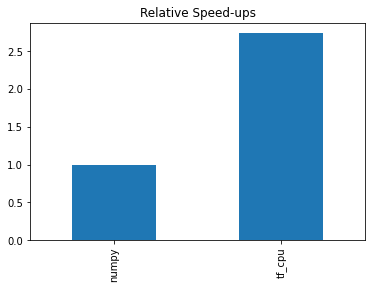

In [14]:
speed_ups.plot.bar(title='Relative Speed-ups', fontsize=10)

## Demonstrate calculating "the greeks" using TF autodiff function

In [15]:
option_data

OptionParameters(stockPrice=120.0, optionStrike=100.0, optionYears=1.0, Riskfree=0.01, Volatility=0.5)

### Setup tensors for calculation

In [16]:
stockPrice = tf.convert_to_tensor(120., dtype=tf.float32, name='stockPrice')
optionStrike = tf.convert_to_tensor(100., dtype=tf.float32, name='optionStrike')
optionYears = tf.convert_to_tensor(1., dtype=tf.float32, name='optionYears')
Riskfree = tf.convert_to_tensor(0.01, dtype=tf.float32, name='Riskfree')
Volatility = tf.convert_to_tensor(0.5, dtype=tf.float32, name='Volatility')

### Define function to calculate greeks using TF autodiff function

Based on discussion found [here](https://quantdare.com/have-you-tried-to-calculate-derivatives-using-tensorflow-2/)

In [17]:
def calc_black_scholes_greeks_autodiff(stockPrice, optionStrike, optionYears, Riskfree, Volatility):
    variables = [stockPrice, optionStrike, optionYears, Riskfree, Volatility]
    
    # invoke TF autodiff function
    with tf.GradientTape(watch_accessed_variables=False) as tape1:
        tape1.watch(stockPrice)
        with tf.GradientTape(watch_accessed_variables=False) as tape2:
            tape2.watch(variables)
            ans = tf_black_scholes(*variables)

        # isolate to only the Call valuation,  otherwise gradient will calculate
        # derivative to the sum of the components of the ans tensor.
        dv = tape2.gradient(ans[0], variables)
    
    # isolate to only the Delta component, otherwise gradient will calculate
    # derivative to the sume of the dv tensor
    d2v = tape1.gradient(dv[0], [stockPrice])

    return {
        'Delta': dv[0].numpy(),
        'Gamma': d2v[0].numpy(),
        'Theta': dv[2].numpy(),
        'Rho': dv[3].numpy(),
        'Vega':dv[4].numpy()
    }

### Calculate greeks via TF autodiff function

In [18]:
auto_diff_greeks = calc_black_scholes_greeks_autodiff(stockPrice, optionStrike, optionYears, Riskfree, Volatility)

### Compute greeks analytically
Greek calculations form this [web page](https://en.wikipedia.org/wiki/Black–Scholes_model).

In [19]:
TF_NORMAL = tfp.distributions.Normal(0., 1.)

def calc_black_scholes_greeks_analytic(stockPrice, optionStrike, optionYears, Riskfree, Volatility):
    S = stockPrice
    X = optionStrike
    T = optionYears
    R = Riskfree
    V = Volatility
    sqrtT = tf.sqrt(T)
    d1 = (tf.math.log(S / X) + (R + 0.5 * V * V) * T) / (V * sqrtT)
    d2 = d1 - V * sqrtT

    cndd1 = TF_NORMAL.cdf(d1)
    cndd2 = TF_NORMAL.cdf(d2)
    pdfd1 = TF_NORMAL.prob(d1)

    expRT = tf.math.exp(- R * T)

    return {
        'Delta': cndd1.numpy(),
        'Gamma': (pdfd1 / (S * V * T)).numpy(),
        'Rho': (X * expRT * cndd2).numpy(),
        'Vega': (S * pdfd1 * T).numpy(),
        'Theta': (-((S * pdfd1 * V) / (2 * sqrtT)) - R * X * expRT * cndd2).numpy()
    }

In [20]:
analytic_greeks = calc_black_scholes_greeks_analytic(stockPrice, optionStrike, optionYears, Riskfree, Volatility)

### Combine analytic and tf autodiff results for comparison

In [21]:
greek_df = pd.DataFrame([pd.Series(auto_diff_greeks), pd.Series(analytic_greeks)]).T.copy()
greek_df.columns = ['tf_auto_diff', 'analytic']
greek_df['match'] = np.isclose(greek_df['tf_auto_diff'], greek_df['analytic'])
greek_df

,tf_auto_diff,analytic,match
Delta,0.737169,0.737169,True
Gamma,0.005436,0.005436,True
Theta,10.333263,-10.333263,False
Rho,54.804504,54.804504,True
Vega,39.140873,39.140873,True
